# Naive Bayes on Amazon Fine FOod Reviews
Naive bayes is simple probabilistic algorithm which uses bayesian theorem for conditional probability.
We assume here conditioinal independence (naive) to simplify our approach.
* We will apply naive bayes on amazon finefood reviews by converting reviews into numerical vectors
* Reviews converted to numerical vectors using two different approachs BagOfWords and Tfidf 
* To determine hyperparameter (Alpha) we will use 10 fold cross validation
* For hyperparameter tunning we will use feature engineering in which we will add top features of Summary text

In [101]:
#importing necessary packages
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pickle
import sklearn.cross_validation
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

## Reading already Cleaned, Preprocessed data from database

After removing stopwords, punctuations, meaningless characters, HTML tags from Text 
and done stemming. Using it directly as it was alredy done in prevoius assignment

In [102]:
#Reading
conn= sqlite3.connect('cleanedTextData.sqlite')
data= pd.read_sql_query('''
SELECT * FROM Reviews
''',conn)
data=data.drop('index',axis=1)
data.shape

(364171, 11)

In [103]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [104]:
data['CleanedText'].head(3)

0    witti littl book make son laugh loud recit car...
1    rememb see show air televis year ago child sis...
2    beetlejuic well written movi everyth act speci...
Name: CleanedText, dtype: object

 ## Sorting on the basis of 'Time' and taking top 100k pts

 This data has time attribute so it will be reasonable to do time based splitting instead
   of random splitting.

 So, before splitting we have to sort our data according to time and here we are taking
 100k points from our dataset(population)

In [ ]:
data["Time"] = pd.to_datetime(data["Time"], unit = "ms")
data = data.sort_values(by = "Time")

In [106]:
#latest 100k points according to time
data= data[:100000]
len(data)

100000

## Splitting data into train70% test30%

Splitting our data into train and test data.
* train data will train our ML model
* cross validataion data will be for determining our hyperparameter
* test data will tell how Generalized our model is
* dataframes after splitting:- traindata, testdata

In [107]:
traindata, testdata= train_test_split(data, test_size= 0.3, shuffle= False,stratify= None)
print(len(traindata),len(testdata))

70000 30000


In [108]:
Xtrain,Xtest= traindata['CleanedText'],testdata['CleanedText']
Ytrain,Ytest= traindata['Score'],testdata['Score']

In [109]:
# converting positive to 1 and negative to 0
Ytrain=Ytrain.map(lambda x:1 if x=='Positive' else 0)
Ytest=Ytest.map(lambda x:1 if x=='Positive' else 0)

Taking Text and score(class) as sequences
* traindata -> Xtrain, Ytrain
* testdata -> Xtest, Ytest

# BOW Vectorization
Bow vectorization is basic technique to convert a text into numerical vector.
* We will build a model on train text using fit-transform
* Then transform (test) text on model build by train text
* Transformed data will be in the form of sparse matrix

In [211]:
# vectorizing X and transforming
bowModel=CountVectorizer()
XtrainV=bowModel.fit_transform(Xtrain.values)

In [212]:
XtestV= bowModel.transform(Xtest)
XtestV.shape

(30000, 39730)

In [ ]:
#Standardizing vectors
std = StandardScaler(with_mean=False).fit(XtrainV)
XtrainV = std.transform(XtrainV)
XtestV = std.transform(XtestV)

We have here vectors from train data and test data ready to get fit into our naive bayes model.
## Finding optimal Hyperparameter alpha for our Naive Bayes
* We will do **hyperparameter tunning** by adding top features of summary vector from reviews
* To do that we will first convert our **summary text** to **summaryVector**
* choose some top features from summary and add it to our original text vectors

### Text preprocessing for summary text

In [114]:
# cleaning punctuations, html tags, lemmitization, stemming and removing stop words
import re
import string
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer as sno
setofstopwords=set(stopwords.words('english'))

def cleanhtml(sentance): #substitute expression contained in <> with ' '
    cleaned= re.sub(re.compile('<.*?>'),' ',sentance)
    return cleaned
#function for removing punctuations chars
def cleanpunc(sentance):
    cleaned= re.sub(r'[?|!|\'|"|#]',r'',sentance)
    cleaned= re.sub(r'[.|,|)|(|\|/]',r'',sentance)
    return cleaned
snowstem= sno('english')

i=0
str1=' '
summary_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for sent in data['Summary'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here 
        # because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" 
        # as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in setofstopwords):
                    s=(snowstem.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if(data['Score'].values)[i] =='Positive':
                        all_positive_words.append(s)
                    if(data['Score'].values)[i] =='Negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    summary_string.append(str1)

In [115]:
# adding cleaned summary text to our reviews data as new column
data['CleanedSummary']=summary_string
data['CleanedSummary']=data['CleanedSummary'].str.decode("utf-8")

In [214]:
#splitting summary data into train and test
sumtraindata, sumtestdata= train_test_split(data['CleanedSummary'], test_size= 0.3, shuffle= False,stratify= None)
print(len(sumtraindata),len(sumtestdata))

70000 30000


In [215]:
# vectorizing X and transforming on summary data
sumbowModel=CountVectorizer(max_features=1000)
sumXtrainV=sumbowModel.fit_transform(sumtraindata.values)
sumXtestV= sumbowModel.transform(sumtestdata)
sumXtestV.shape

(30000, 1000)

In [ ]:
#Standardizing the vector
std = StandardScaler(with_mean=False).fit(sumXtrainV)
sumXtrainV = std.transform(sumXtrainV)
sumsumXtestV = std.transform(sumXtestV)

* Finally we have both summary vectors and text review vectors. Now we will join both by taking top 1000 features of 
  summary 

In [121]:
from scipy.sparse import hstack
finaltrain=hstack((XtrainV,sumXtrainV))
finaltest=hstack((XtestV,sumXtestV))

In [122]:
finaltrain.shape

(70000, 40730)

* Now we will find optimal hyperparameter
### function to return optimal hyperparameter

In [138]:
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
def alpha_multinomialnb(finaltrain, ytrain):
 
    alpha_values = np.linspace(0.000001,1,50)
    cv_scores=[]
    # performing for different alpha
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, finaltrain, ytrain, cv = 10, scoring = 'f1')
        cv_scores.append(scores.mean())
    
    # determining best alpha
    optimal_alpha = alpha_values[cv_scores.index(max(cv_scores))]
    print('\nThe optimal number of alpha_values is ' ,optimal_alpha)

    # plot alpha vs f1 score 
    plt.plot(alpha_values, cv_scores)

    plt.title("F1 Score vs alpha")
    plt.xlabel('Number of alpha_values')
    plt.ylabel('F1 score')
    plt.show()
    print("the F1 for each alpha value is : ", np.round(cv_scores,3))
    print('With f1_score as ',max(cv_scores))
    return optimal_alpha


The optimal number of alpha_values is  1e-06


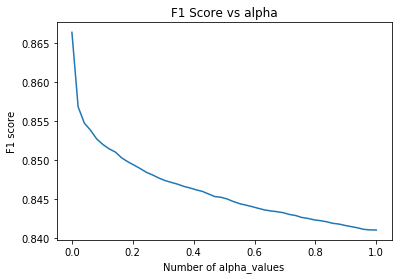

the F1 for each alpha value is :  [0.866 0.857 0.855 0.854 0.853 0.852 0.851 0.851 0.85  0.85  0.849 0.849
 0.848 0.848 0.848 0.847 0.847 0.847 0.847 0.846 0.846 0.846 0.846 0.845
 0.845 0.845 0.845 0.844 0.844 0.844 0.844 0.844 0.843 0.843 0.843 0.843
 0.843 0.843 0.842 0.842 0.842 0.842 0.842 0.842 0.842 0.841 0.841 0.841
 0.841 0.841]
With f1_score as  0.8663818874954738


In [139]:
# calling our function for optimal alpha
a=alpha_multinomialnb(finaltrain, Ytrain)

In [160]:
# Now training our model after getting optimal hyperparameter a
mnb= MultinomialNB(alpha=a)
mnb.fit(XtrainV,Ytrain)
pred=mnb.predict(XtestV)

## Feature importance

In [161]:
bow_features= bowModel.get_feature_names()

In [162]:
len(bow_features)

39730

In [163]:
feat_count = mnb.feature_count_
feat_count.shape

(2, 39730)

In [164]:
log_prob = mnb.feature_log_prob_
log_prob

array([[-28.99921295, -28.99921295, -28.99921295, ..., -28.99921295,
        -28.99921295, -28.99921295],
       [-11.48441702, -11.48441702, -11.48441702, ..., -11.48441702,
        -11.48441702, -11.48441702]])

In [165]:
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(39730, 2)

In [166]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast         -6.490837
product      -6.577409
like         -6.611412
disappoint   -6.636449
would        -6.681984
one          -6.811073
tri          -6.860446
bad          -6.870958
buy          -6.876838
money        -6.907528
Name: 0, dtype: float64


 Top 10 Positive Features:-
 great    -6.619207
love     -6.645909
good     -6.675704
like     -6.703197
tast     -6.706566
tri      -6.847749
flavor   -6.854190
one      -6.856025
make     -6.875910
use      -6.890117
Name: 1, dtype: float64


## Checking performance of our model using different metrics

accuracy on test data 0.8152666666666667
             precision    recall  f1-score   support

          0       0.38      0.56      0.45      4098
          1       0.93      0.86      0.89     25902

avg / total       0.85      0.82      0.83     30000



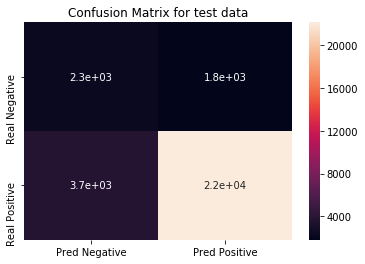

In [175]:
from sklearn.metrics import classification_report
print('accuracy on test data',accuracy_score(Ytest,pred))
print(classification_report(Ytest,pred))

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(Ytest,pred).ravel()
cfm= confusion_matrix(Ytest,pred)
df_cm = pd.DataFrame(cfm,columns = ['Pred Negative','Pred Positive']\
                     ,index = ['Real Negative','Real Positive'])
plt.title('Confusion Matrix for test data')
sns.heatmap(df_cm, annot=True)


In [184]:
print(' TN {}\n FP {}\n FN {}\n TP {}'.format(tn,fp,fn,tp))

 TN 2305
 FP 1793
 FN 3749
 TP 22153


#### Confusion matrix on train data

In [172]:
predtr=mnb.predict(XtrainV)

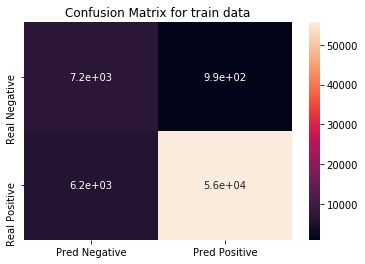

In [177]:
cfm= confusion_matrix(Ytrain,predtr)
df_cm = pd.DataFrame(cfm,columns = ['Pred Negative','Pred Positive']\
                     ,index = ['Real Negative','Real Positive'])
plt.title('Confusion Matrix for train data')
sns.heatmap(df_cm, annot=True)

## Observations:-
* Test data accuracy = 81.52%
* F1 score of test data = 83%
* precision = 85%
* Average recall= 82%
* sensitivity= 86%
* specificity= 56%
* TN = 2305,  FP = 1793, FN = 3749, TP = 22153
* F1 score on train data = 86.6%

***
# TFIDF vectorization

* We will build a model on train text using fit-transform
* Then transform (test) text on model build by train text
* Transformed data will be in the form of sparse matrix
* Then Standardize our data

In [206]:
# generating vetor out of text using tfidf
model=TfidfVectorizer()
XtrainV= model.fit_transform(Xtrain)
XtestV= model.transform(Xtest)

In [207]:
std= StandardScaler(with_mean=False)
XtrainV = std.fit_transform(XtrainV)
XtestV = std.transform(XtestV)

In [208]:
# generating vector out of summary text data using Tfidf
tfidf= TfidfVectorizer(max_features=100)
sumXtrainV= tfidf.fit_transform(sumtraindata)
sumXtestV= tfidf.transform(sumtestdata)

In [209]:
#adding features of summary to original text data
from scipy.sparse import hstack
finaltrainTF= hstack((XtrainV,sumXtrainV))
finaltestTF= hstack((XtestV,sumXtestV))

We now have final test and train data to get our optimal hyperparameter.

calling our function which applies 10 fold CV and return optimal alpha


The optimal number of alpha_values is  1e-06


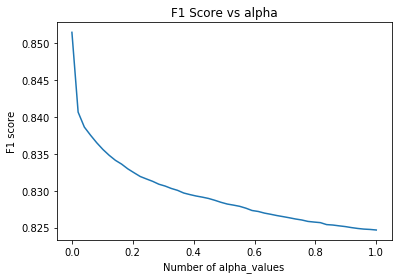

the F1 for each alpha value is :  [0.851 0.841 0.839 0.838 0.836 0.836 0.835 0.834 0.834 0.833 0.832 0.832
 0.832 0.831 0.831 0.831 0.83  0.83  0.83  0.829 0.829 0.829 0.829 0.829
 0.828 0.828 0.828 0.828 0.828 0.827 0.827 0.827 0.827 0.827 0.826 0.826
 0.826 0.826 0.826 0.826 0.826 0.825 0.825 0.825 0.825 0.825 0.825 0.825
 0.825 0.825]
With f1_score as  0.8514532931742563


In [210]:
# getting optimal alpha
aTF= alpha_multinomialnb(finaltrainTF,Ytrain)

In [192]:
# training our data on optimal alpha
mnbTF= MultinomialNB(alpha=a)
mnbTF.fit(XtrainV,Ytrain)
predTF=mnbTF.predict(XtestV)

### Feature importance

In [193]:
tfidf_features= model.get_feature_names()

In [194]:
feat_count = mnbTF.feature_count_
feat_count.shape

(2, 39730)

In [195]:
log_prob = mnbTF.feature_log_prob_
log_prob

array([[-28.9476787 , -28.9476787 , -28.9476787 , ..., -28.9476787 ,
        -28.9476787 , -28.9476787 ],
       [-11.44877052, -11.44877052, -11.44877052, ..., -11.44877052,
        -11.44877052, -11.44877052]])

In [196]:
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(39730, 2)

In [197]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast         -6.451784
like         -6.554001
disappoint   -6.633624
product      -6.653287
would        -6.673563
one          -6.820320
bad          -6.887859
tri          -6.925399
money        -6.942010
wast         -6.961842
Name: 0, dtype: float64


 Top 10 Positive Features:-
 tast     -6.638577
like     -6.658380
great    -6.659154
love     -6.668336
good     -6.692609
flavor   -6.763374
use      -6.810635
one      -6.822044
tri      -6.837382
make     -6.846759
Name: 1, dtype: float64


## Checking performance of our model

accuracy on test data 0.816
             precision    recall  f1-score   support

          0       0.38      0.55      0.45      4098
          1       0.92      0.86      0.89     25902

avg / total       0.85      0.82      0.83     30000



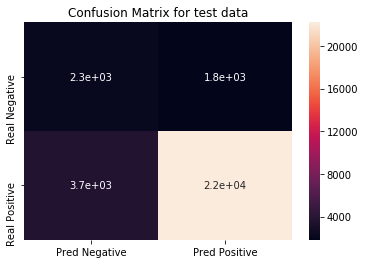

In [202]:
from sklearn.metrics import classification_report
print('accuracy on test data',accuracy_score(Ytest,predTF))
print(classification_report(Ytest,predTF))

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(Ytest,predTF).ravel()
cfm= confusion_matrix(Ytest,predTF)
df_cm = pd.DataFrame(cfm,columns = ['Pred Negative','Pred Positive']\
                     ,index = ['Real Negative','Real Positive'])
plt.title('Confusion Matrix for test data')
sns.heatmap(df_cm, annot=True)


In [203]:
print(' TN {}\n FP {}\n FN {}\n TP {}'.format(tn,fp,fn,tp))

 TN 2268
 FP 1830
 FN 3690
 TP 22212


#### Confusion matrix on train data

In [204]:
predtrTF=mnbTF.predict(XtrainV)

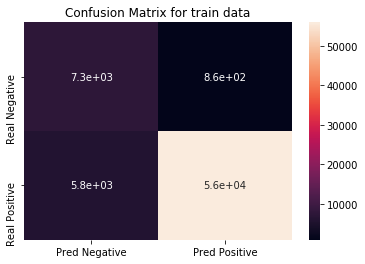

In [205]:
cfm= confusion_matrix(Ytrain,predtrTF)
df_cm = pd.DataFrame(cfm,columns = ['Pred Negative','Pred Positive']\
                     ,index = ['Real Negative','Real Positive'])
plt.title('Confusion Matrix for train data')
sns.heatmap(df_cm, annot=True)

## Observations:-
* Test data accuracy = 81.6%
* F1 score of test data = 83%
* precision = 85%
* Average recall= 82%
* sensitivity= 86%
* specificity= 55%
* TN = 2268, FP = 1830, FN =  3690, TP = 22212
* F1 score on train data= 85.15%
***
# <center>Summary</center>
Vectorization|Accuracy|F1 score|Precision|Recall|Sensitivity|Specificity|True positive|False positive|False Negative|True positive
---|---|---|---|---|---|---|---|---|---|---
Bow|81.52|83|85|82|86|56|2305|1793|3749|22153
Tfidf|81.6|83|85|82|86|55|2268|1830|3690|22212

In [4]:
print('End\n\n\n\n')

End




